# **Задание 1. Дискретная марковская цепь**

**Условие:** у нас три состояния $S = {0, 1, 2}$ и на каждом шаге из состояния $i$ мы с вероятностью $1 - \beta$ остаемся в том эе состоянии, а с вероятностью $\beta = 0.1$ переходим равновероятно в любое другое состояние

**1. Построение переходной матрицы $P$**

Для трех состояний матрица $P$ имеет размер $3 \times 3$. Элемент $P_{ij} = q(x_i = j | x_{t1} = 1)$.

- Если $i = j$, то:
$$P_{ij} = 1 - \beta = 0.9$$

- Если $i \ne j$, то из $i$ перейти в любую из двух других состояний с общей вероятностью $\beta$, то есть

$$P_{ij} = \frac{\beta}{2} = \frac{0.1}{2} = 0.05$$

Следовательно:

$$ P =
\left(
\begin{matrix}  
0.9 & 0.05 & 0.05\\  
0.05 & 0.9 & 0.05 \\
0.05 & 0.05 & 0.9 
\end{matrix}
\right)$$ 

**2. Нахождение станционарного распределения $\pi$**

Станционарное распределение $\pi = (\pi_0, \pi_1, \pi_2)$ удовлетворяет

$$\pi = \pi P,   \sum_{i=0}^2\pi_i = 1.$$


То есть система уровнений:

$$
\begin{cases}  
    \pi_0 = 0.9\pi_0 + 0.05\pi_1 + 0.05\pi_2 \\  
    \pi_0 = 0.05\pi_0 + 0.9\pi_1 + 0.05\pi_2 \\  
    \pi_0 = 0.05\pi_0 + 0.05\pi_1 + 0.9\pi_2 \\  
    \pi_0 + \pi_1 + \pi_2 = 1  
\end{cases}  
$$

Из симметрии видно, что $\pi_0 = \pi_1 = \pi_2$. Тогда

$$3\pi_0 = 1  =>  \pi_0 = \frac{1}{3}$$

Итак,

$$\pi = \left(\frac{1}{3},\frac{1}{3},\frac{1}{3}\right)$$



---------------------------------
**Выводы:**
- Переходная матрица

$$ P =
\left(
\begin{matrix}  
0.9 & 0.05 & 0.05\\  
0.05 & 0.9 & 0.05 \\
0.05 & 0.05 & 0.9 
\end{matrix}
\right)$$ 

- Станционарное распределение

$$\pi = \left(\frac{1}{3},\frac{1}{3},\frac{1}{3}\right)$$

# **Задание 2: Прямая диффузия на MNIST**

**Цель:** 
Научиться **добавлять шум к изображениям** шаг за шагом, чтобы симулировать *forward process* в DDPM

**DDPM (Denoising Diffusion Probalistic Model)** - это тип генеративной модели предложенной в статье [Ho et al., 2020](https://arxiv.org/abs/2006.11239), которая учится **генерировать данные (например изображения) из случайного шума**, проходя через серию обученных шагов по "отшумлению"

In [1]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 

In [2]:
# --------------------------
# Настройки
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
T = 1000  # число шагов диффузии

cpu


In [3]:
# Линейное расписание β от 1e-4 до 0.02
beta = torch.linspace(1e-4, 0.02, T)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)

# --------------------------
# Датасет: MNIST
# --------------------------
transform = transforms.Compose([
    transforms.ToTensor(),           # [0, 1]
    transforms.Lambda(lambda x: x * 2. - 1.)  # [-1, 1]
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Получим один пример
x0, _ = next(iter(loader))
x0 = x0.to(device)  # (1, 1, 28, 28)


In [4]:
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise


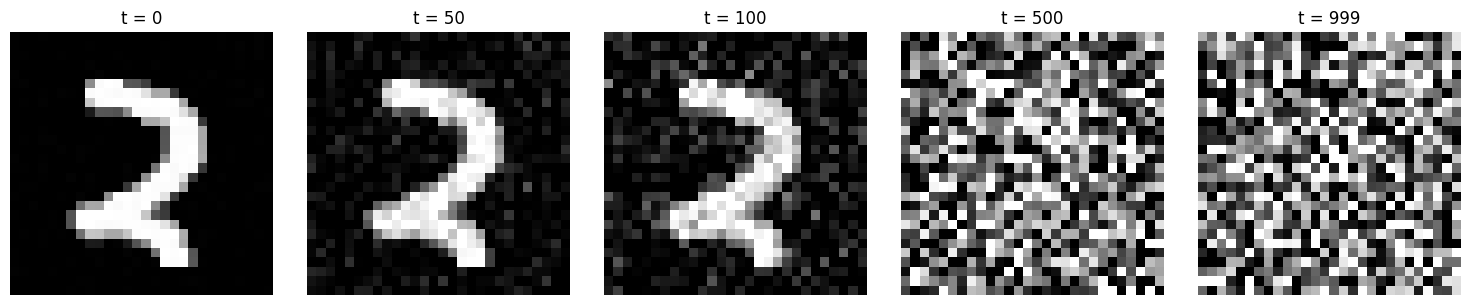

In [5]:
# Визуализируем x0 и его зашумленные версии на разных шагах
timesteps = [0, 50, 100, 500, 999]
fig, axs = plt.subplots(1, len(timesteps), figsize=(15, 3))

for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t], device=device)
    x_t = q_sample(x0, t_tensor).cpu().squeeze().clamp(-1, 1)
    axs[i].imshow((x_t + 1) / 2., cmap='gray')
    axs[i].set_title(f"t = {t}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [6]:
from PIL import Image

# Путь к твоему файлу
image_path = 'rei1.jpg'  # замени на путь к своей картинке

# Загружаем и преобразуем в тензор [-1, 1]
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Подгоняем размер (можно другое)
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)  # Приводим в диапазон [-1, 1]
])

image = Image.open(image_path).convert("RGB")
x0 = transform(image).unsqueeze(0).to(device)  # (1, 3, 128, 128)


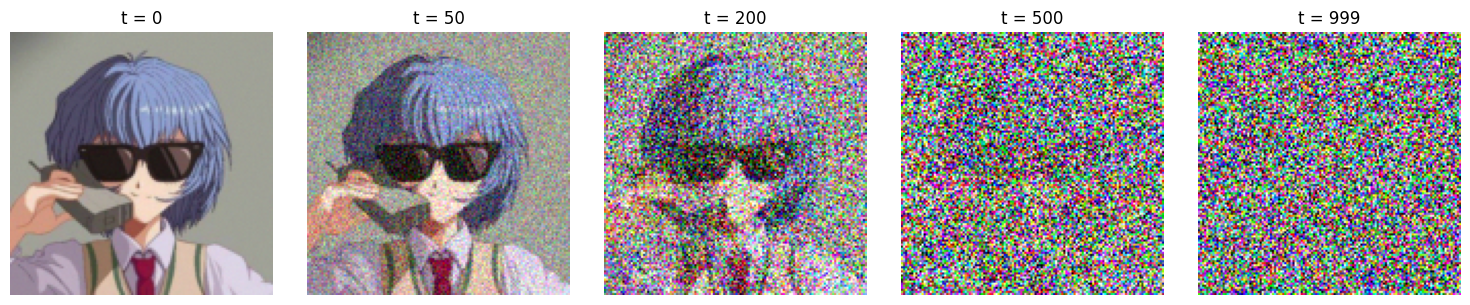

In [10]:
timesteps = [0, 50, 200, 500, 999]
fig, axs = plt.subplots(1, len(timesteps), figsize=(15, 3))

for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t], device=device)
    x_t = q_sample(x0, t_tensor).cpu().squeeze().permute(1, 2, 0).clamp(-1, 1)
    axs[i].imshow((x_t + 1) / 2.)  # переводим обратно в [0, 1]
    axs[i].set_title(f"t = {t}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## Статья с хабр

In [11]:
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

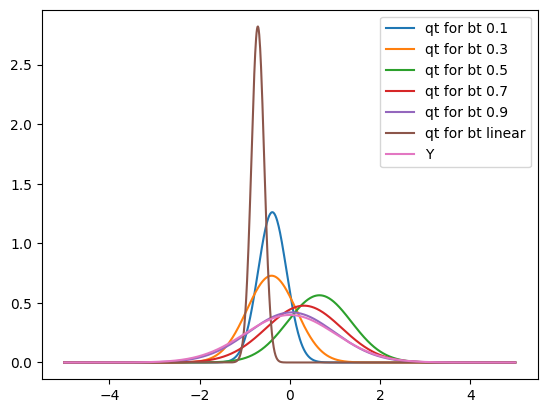

In [12]:
timestep = 800

xs = np.arange(-5, 5, 0.01)

y_results = norm.pdf(xs, 0, 1)

different_schedules = [
    # Constant
    np.ones(timestep) * 0.1,
    np.ones(timestep) * 0.3,
    np.ones(timestep) * 0.5,
    np.ones(timestep) * 0.7,
    np.ones(timestep) * 0.9,
    
    # Linear change (from paper)
    np.linspace(1e-4, 0.02, timestep)
]

x0 = 1

for bt in different_schedules:
    
    # Set xt to zero, which will be used as
    # x(t-1) like in sqrt(1-b) * x(t-1)
    xt = x0

    # A simple loop by timestep
    for t in range(timestep):
        
        # Calculate the mean as in the formula
        mean = math.sqrt(1 - bt[t]) * xt

        # Calculate thr variance
        variance = bt[t]

        # Q is a normal distribution, so to get the next xt, 
        # we just get random element from our distribution
        xt = np.random.normal(mean, math.sqrt(variance))
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label = f'qt for bt {bt[0] if bt[0] == bt[-1] else "linear"}')
plt.plot(xs, y_results, label='Y')
plt.legend()
plt.show()


Из-за строчки:
```py
xt = np.random.normal(mean, math.sqrt(variance))
```

мы не можем сделать производную (случ значения), но можно использовать **`reparametrization trick`** чтобы обойти это 

[]

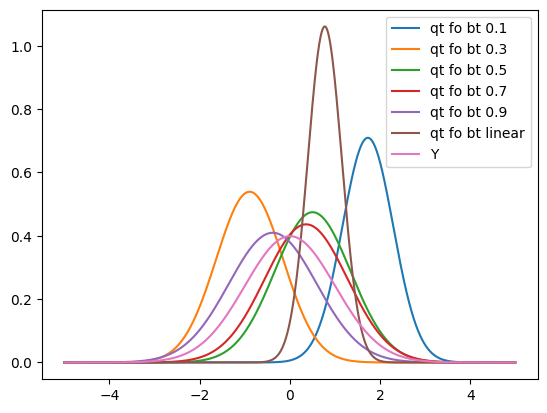

In [13]:
for bt in different_schedules:
    
    # Set xt to zero, which will be used as x(t-1) like in sqrt(1-b) * x(t-1)
    xt = x0
    # A simple loop by timestep
    for t in range(timestep):

        # Calculate the mean as in the formula
        mean = math.sqrt(1-bt[t]) * xt
        
        # Calculate the variance
        variance = math.sqrt(bt[t])

        # Get epsilon from normal distribution
        eps = np.random.normal(0,1)

        # Calculate xt
        xt = mean + variance * eps
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(
        xs,
        q_results,
        label = f'qt fo bt {bt[0] if bt[0] == bt[-1] else "linear"}'
    )
plt.plot(xs, y_results, label='Y')
plt.legend()
plt.plot()

эти способы занимают много выч мощности, вспоминаем тервер и улучшаем

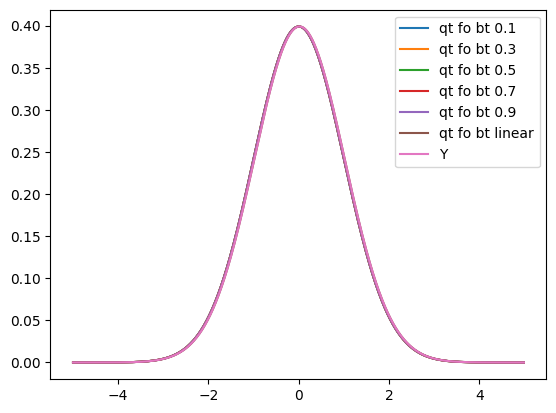

In [14]:
for bt in different_schedules:
    alpha_t = 1 - bt
    cumprod_alpha_t = np.cumprod(alpha_t)
    mean = math.sqrt(cumprod_alpha_t[-1]) * x0
    variance = math.sqrt(1 - cumprod_alpha_t[-1])
    eps = np.random.normal(0, 1)
    xt = mean + eps * variance
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(
        xs,
        q_results,
        label = f'qt fo bt {bt[0] if bt[0] == bt[-1] else "linear"}'
    )
plt.plot(xs, q_results, label='Y')
plt.legend()
plt.show()

Такая формула ведет нас к нормальному распределению с ожиданием 0 и дисперсией 1 в итоге

обратный процесс

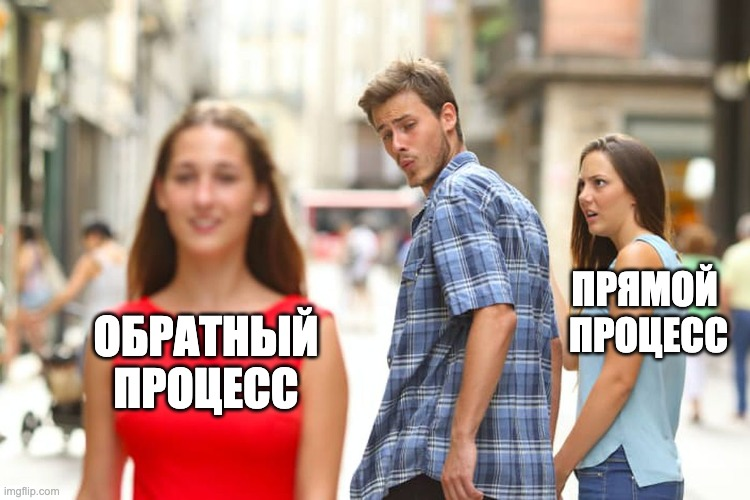

> спойлер: очень много непростой математики 

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [16]:
class DDPM():
    # Конструктор класса
    def __init__(self, T, eps_model, device):
        self.T = T
        self.eps_model = eps_model.to(device)
        self.device = device
        beta_schedule = torch.linspace(1e-4, 0.02, T + 1, device=device)
        alpha_t_schedule = 1 - beta_schedule
        bar_alpha_t_schedule = torch.cumprod(alpha_t_schedule.detach().cpu(), 0).to(device)
        sqrt_bar_alpha_t_schedule = torch.sqrt(bar_alpha_t_schedule)
        sqrt_minus_bar_alpha_t_schedule = torch.sqrt(1-bar_alpha_t_schedule)
        self.register_buffer("beta_schedule", beta_schedule)
        self.register_buffer("alpha_t_schedule", alpha_t_schedule)
        self.register_buffer("bar_alpha_t_schedule", bar_alpha_t_schedule)
        self.register_buffer("sqrt_bar_alpha_t_schedule", sqrt_bar_alpha_t_schedule)
        self.register_buffer("sqrt_minus_bar_alpha_t_schedule", sqrt_minus_bar_alpha_t_schedule)
        self.criterion = nn.MSELoss()

## DeepSeek

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

In [3]:
# Параметры модели
image_size = 28  # Размер изображения MNIST
channels = 1     # Градации серого
batch_size = 128
timesteps = 1000 # Количество шагов диффузии
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Расписание бета
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# Расчет коэффициентов
betas = linear_beta_schedule(timesteps)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Исправленная U-Net модель
class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Энкодер
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.down1 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.down2 = nn.MaxPool2d(2)
        
        # Боттлнек
        self.bottleneck1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bottleneck2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        # Декодер
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.final = nn.Conv2d(64, channels, kernel_size=1)
        
        # Временные embedding
        self.time_embed = nn.Embedding(timesteps, 256)
        self.time_linear = nn.Linear(256, 256)
        
    def forward(self, x, t):
        # Временные embedding
        t_emb = self.time_embed(t)
        t_emb = self.time_linear(t_emb)
        t_emb = t_emb.view(-1, 256, 1, 1)
        
        # Энкодер
        x1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x1))
        x1_pool = self.down1(x1)
        
        x2 = F.relu(self.conv3(x1_pool))
        x2 = F.relu(self.conv4(x2))
        x2_pool = self.down2(x2)
        
        # Боттлнек + временные embedding
        x = F.relu(self.bottleneck1(x2_pool))
        x = F.relu(self.bottleneck2(x) + t_emb)
        
        # Декодер
        x = self.up1(x)
        x = torch.cat([x, x2], dim=1)  # Конкатенация с x2
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        
        x = self.up2(x)
        x = torch.cat([x, x1], dim=1)  # Конкатенация с x1
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        
        return self.final(x)

# Прямой процесс: добавление шума
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    
    sqrt_alpha_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    
    return sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise

# Обратный процесс
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = betas[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t]).view(-1, 1, 1, 1)
    
    pred_noise = model(x, t)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)
    
    if t_index == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(betas[t]) * noise

# Генерация изображений
@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=1):
    img = torch.randn((batch_size, channels, image_size, image_size), device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='Sampling'):
        img = p_sample(
            model, 
            img, 
            torch.full((batch_size,), i, device=device, dtype=torch.long), 
            i
        )
        if i % 100 == 0:
            imgs.append(img.cpu().numpy())
    return imgs

# Обучение модели
def train():
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = DiffusionModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epochs = 5  # Уменьшено для быстрого тестирования
    
    for epoch in range(epochs):
        for step, (images, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}")):
            images = images.to(device)
            
            t = torch.randint(0, timesteps, (images.shape[0],), device=device).long()
            noise = torch.randn_like(images)
            noisy_images = q_sample(images, t, noise)
            
            pred_noise = model(noisy_images, t)
            loss = F.mse_loss(pred_noise, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if step % 200 == 0:
                print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
    
    torch.save(model.state_dict(), "diffusion_model.pth")
    samples = sample(model, image_size, 16, channels)
    plot_samples(samples[-1])

# Визуализация
def plot_samples(samples):
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    samples = samples.squeeze()
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig("generated_samples.png")
    plt.show()

In [ ]:
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[5], line 1
----> 1 plot_samples()

TypeError: plot_samples() missing 1 required positional argument: 'samples'

In [5]:
plot_samples()

TypeError: plot_samples() missing 1 required positional argument: 'samples'

In [10]:
train()

Epoch 1:   0%|          | 1/469 [00:01<09:12,  1.18s/it]

Epoch 0 | Step 0 | Loss: 1.0102


Epoch 1:   2%|▏         | 9/469 [00:10<09:03,  1.18s/it]


KeyboardInterrupt: 